<h1><center> Exploring occurrence data from GBIF</center></h1>
<h2><center>University of Brasília Herbarium dataset</center></h2>

<h4><center>Author: Pedro Correia de Siracusa</center></h4>
<h4><center>Date: Apr 30, 2017</center></h4>

---

On this notebook I'll perform a preliminary exploratory analysis on the species occurrence from the University of Brasília Herbarium dataset, made available through the Global Biodiversity Information Facility (GBIF) initiative. Here my overall goals are to explore:

* General Structure of the dataset;
* Main issues and aspects regarding data veracity;
* Geographical distribution of the available data;
* Possible network approaches based on observational data;

<h3>Table of Contents</h3>

<ul>
    <li><a href="#1">1. Importing UnB herbarium dataset</a>
    </li>
    
    <li><a href="#2">2. Dataset structure</a>
        <ul>
            <li><a href="#2.1">2.1 Data issues</a></li>
            <li><a href="#2.2">2.2 Geographic distribution of the dataset</a></li>
        </ul>
    </li>
    
    <li><a href="#3">3. Network Models</a>
        <ul>
            <li><a href="#3.1">3.1 Collector-species network at Fazenda Água Limpa</a>
                <ul>
                    <li><a href="#3.1.1">3.1.1 Who have collected more species?</a></li>
                    <li><a href="#3.1.2">3.1.2 Which species were most collected by different collectors?</a></li>
                    <li><a href="#3.1.3">3.1.3 Which colletors are specialists and which are generalists?</a></li>                
                </ul>
            </li>
            
            <li><a href="#3.2">3.2 Species co-occurrence network</a>
                <ul>
                    <li><a href="#3.2.1">3.2.1 Species co-occurrence at the state scale</a></li>
                    <li><a href="#3.2.2">3.2.2 Species co-occurrence at the locality scale</a></li>              
                </ul>
            </li>
        </ul>           
    </li>
    
    <li><a href="#4">4. Conclusions</a>
    </li>
</ul>        

Let's get started by importing some basic python libraries for data analysis.

In [1]:
import os
import urllib
import zipfile

import numpy as np
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import mpld3

import networkx as nx
import networkx.algorithms.bipartite as bipartite

from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

from IPython.display import display
pd.set_option('display.max_columns', None)

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

# 1. Importing UnB herbarium dataset
<a name="1"></a>

As I have already previously requested the dataset download from my gbif account, I can now download the dataset to my local machine, under the same directory as this notebook. The download id is used as the identifier. If the dataset is already on this machine, download is skipped. I will also download the shapefiles for Brazilian administrative regions (for geographic plotting).

In [2]:
from pygbif import occurrences as occ

dld_id='0077202-160910150852091' # this is my download id of the UnB herbarium dataset on GBIF

def getHerbariumDataset(dld_id):
    archive_filename = dld_id+'.zip'
    
    occ.download_get(dld_id)
    with zipfile.ZipFile(archive_filename, "r") as archive:
        archive.extractall(dld_id)
        
    os.remove(archive_filename)

    
if not os.path.isdir(dld_id):
    getHerbariumDataset(dld_id)

In [3]:
br_adm_areas_url = 'http://biogeo.ucdavis.edu/data/gadm2.8/shp/BRA_adm_shp.zip'
    
def getShapefiles(url):
    archive_filename, headers = urllib.request.urlretrieve(url)

    with zipfile.ZipFile(archive_filename, 'r') as archive:
        archive.extractall("./shapefiles")

    os.remove(archive_filename)
    
    
if not os.path.isdir("./shapefiles"):
    getShapefiles(br_adm_areas_url)

# 2. Dataset structure
<a name="2"></a>

In order to choose relevant columns for the analysis, we must first take a look at the available column set. Below there is a list of all the columns that describe the dataset. I have already filter the ones with NA's for the first 1000 entries, as I assumed they are empty. For this notebook I'm only interested on the entries which refer to the taxonomic level of 'SPECIES', and which are assigned to some municipality.

In [4]:
dset_head = pd.read_csv('./0077202-160910150852091/occurrence.txt', sep='\t', nrows=1000)
colsList = sorted( [ e for e,cnt in dset_head.notnull().sum().items() if cnt>0] )
dset_head[colsList].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 62 columns):
basisOfRecord           1000 non-null object
catalogNumber           1000 non-null int64
class                   1000 non-null object
classKey                1000 non-null int64
collectionCode          1000 non-null object
continent               1000 non-null object
countryCode             1000 non-null object
datasetKey              1000 non-null object
datasetName             1000 non-null object
dateIdentified          507 non-null object
day                     908 non-null float64
decimalLatitude         1000 non-null float64
decimalLongitude        1000 non-null float64
elevation               1000 non-null float64
elevationAccuracy       1000 non-null float64
eventDate               970 non-null object
family                  1000 non-null object
familyKey               1000 non-null int64
gbifID                  1000 non-null int64
genericName             1000 non-null obj

From the list of valid columns I'll select a subset to work with, and read the entire dataset

In [5]:
colsList = ['scientificName', 'taxonRank', 'family', 
            'stateProvince', 'locality', 'municipality', 'countryCode', 
            'hasCoordinate', 'decimalLatitude', 'decimalLongitude',
            'recordedBy', 'identifiedBy', 'occurrenceRemarks',
            'eventDate', 'issue']

In [6]:
ub_dset = pd.read_csv('./0077202-160910150852091/occurrence.txt', sep='\t', 
                 warn_bad_lines=False, 
                 error_bad_lines=False, 
                 usecols=colsList)

In [7]:
ub_dset.head()

recordedBy  \
0  Anderson, WR; Arroyo, MTK; Hill, SR; Santos, R...   
1                    Irwin, HS; Souza, R; Santos, RR   
2                             Heringer, EP; Eiten, G   
3       Anderson, WR; Hill, SR; Santos, RR; Souza, R   
4                         Harley, RM; Giulietti, AML   

                                   occurrenceRemarks          eventDate  \
0  Rocky slope.; Shrub 0,5 m. Fruto green, mature...  1973-03-11T01:00Z   
1  Corolla white.; Shrub 1 m. Fruto green, maturi...  1965-12-03T01:00Z   
2  Soil full of quartz stones derived from quartz...  1974-12-20T01:00Z   
3                  Shrub 0,4 m. Fruto red.; Cerrado.  1973-05-11T01:00Z   
4                           Small tree 3 m; Cerrado.  1968-12-26T01:00Z   

  countryCode stateProvince  municipality  \
0          BR         Goiás           NaN   
1          BR         Goiás           NaN   
2          BR         Goiás  Caldas Novas   
3          BR         Goiás           NaN   
4          BR         Goiás   Pirenópolis   

                                            locality  decimalLatitude  \
0                    8 km by road W of Monte Alegre.             0.00   
1   Serra de Pirineus. 20 km S. of Corumbá de Goiás.           -16.00   
2  At headwaters of creek, Rio Quente, near hotel...           -17.80   
3             Serra Dourada. 16 km S of Goiás Velho.             0.00   
4                                                NaN           -15.75   

   decimalLongitude  identifiedBy                     scientificName  \
0              0.00  Delprete, PG       Sabicea brasiliensis Wernham   
1            -49.00  Delprete, PG       Sabicea brasiliensis Wernham   
2            -48.75  Delprete, PG       Sabicea brasiliensis Wernham   
3              0.00  Delprete, PG       Sabicea brasiliensis Wernham   
4            -48.75  Delprete, PG  Rudgea viburnoides (Cham.) Benth.   

      family taxonRank                                              issue  \
0  Rubiaceae   SPECIES  ZERO_COORDINATE;GEODETIC_DATUM_ASSUMED_WGS84;C...   
1  Rubiaceae   SPECIES                       GEODETIC_DATUM_ASSUMED_WGS84   
2  Rubiaceae   SPECIES                       GEODETIC_DATUM_ASSUMED_WGS84   
3  Rubiaceae   SPECIES  ZERO_COORDINATE;GEODETIC_DATUM_ASSUMED_WGS84;C...   
4  Rubiaceae   SPECIES                       GEODETIC_DATUM_ASSUMED_WGS84   

  hasCoordinate  
0          True  
1          True  
2          True  
3          True  
4          True

As stated above, for the purposes of this exploratory notebook I will filter records associated to municipality data and which taxonomic resolution is at the SPECIES level.

In [8]:
ub_dset = ub_dset[(ub_dset['taxonRank']=='SPECIES') & (ub_dset['municipality'].notnull())]

## 2.1 Data Issues
<a name="2.1"></a>

GBIF does a preprocessing on the dataset, identifying entries which are associated to a possible issue. These were the issues identified on this dataset, associated with their counts.

In [9]:
issues = pd.DataFrame( ub_dset['issue'].value_counts() ).reset_index()
issues.columns=['Issues', 'Count']

In [10]:
issues

Issues  Count
0                        GEODETIC_DATUM_ASSUMED_WGS84  35677
1   ZERO_COORDINATE;GEODETIC_DATUM_ASSUMED_WGS84;C...  25940
2   GEODETIC_DATUM_ASSUMED_WGS84;IDENTIFIED_DATE_U...  20420
3   ZERO_COORDINATE;GEODETIC_DATUM_ASSUMED_WGS84;C...  14384
4   GEODETIC_DATUM_ASSUMED_WGS84;TAXON_MATCH_HIGHE...   2434
5   ZERO_COORDINATE;GEODETIC_DATUM_ASSUMED_WGS84;C...   1152
6      GEODETIC_DATUM_ASSUMED_WGS84;TAXON_MATCH_FUZZY    453
7   ZERO_COORDINATE;GEODETIC_DATUM_ASSUMED_WGS84;C...    420
8   GEODETIC_DATUM_ASSUMED_WGS84;TAXON_MATCH_FUZZY...    209
9   ZERO_COORDINATE;GEODETIC_DATUM_ASSUMED_WGS84;C...    172
10  GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_NEGATED_...     81
11  GEODETIC_DATUM_ASSUMED_WGS84;TAXON_MATCH_HIGHE...     38
12  ZERO_COORDINATE;GEODETIC_DATUM_ASSUMED_WGS84;C...     26
13  GEODETIC_DATUM_ASSUMED_WGS84;COUNTRY_COORDINAT...     22
14  GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_NEGATED_...     21
15  GEODETIC_DATUM_ASSUMED_WGS84;COUNTRY_COORDINAT...     17
16  GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_SWAPPED_...      9
17  GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_NEGATED_...      6
18  GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_NEGATED_...      5
19  GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_SWAPPED_...      5
20  GEODETIC_DATUM_ASSUMED_WGS84;PRESUMED_NEGATED_...      4
21  GEODETIC_DATUM_ASSUMED_WGS84;COUNTRY_DERIVED_F...      3
22  GEODETIC_DATUM_ASSUMED_WGS84;COUNTRY_DERIVED_F...      2

This row contains non-atomic data. It will require some processing for get this info. In fact I'll need to restructure this data. Also, it might be informative to know the percentage of the data containing each issue.

In [11]:
num_of_records = issues['Count'].sum()

issues_dict = dict([ (issue,0) for idx,row in issues.iterrows() for issue in row['Issues'].split(';') ])

for idx,row in issues.iterrows():
    for key in issues_dict.keys():
        if key in row['Issues']:
            issues_dict[key]+=row['Count']
            
issues = pd.Series(issues_dict).reset_index()
issues.columns = ['Issue', 'Count']
issues['Percentual'] = issues['Count'].apply(lambda r: r/num_of_records*100 )

In [12]:
issues.sort_values(by='Percentual', ascending=False)

Issue   Count  Percentual
2      GEODETIC_DATUM_ASSUMED_WGS84  101500  100.000000
0       COUNTRY_COORDINATE_MISMATCH   42133   41.510345
9                   ZERO_COORDINATE   42094   41.471921
3          IDENTIFIED_DATE_UNLIKELY   35360   34.837438
8            TAXON_MATCH_HIGHERRANK    3650    3.596059
7                 TAXON_MATCH_FUZZY    1254    1.235468
5        PRESUMED_NEGATED_LONGITUDE     108    0.106404
4         PRESUMED_NEGATED_LATITUDE      15    0.014778
6       PRESUMED_SWAPPED_COORDINATE      14    0.013793
1  COUNTRY_DERIVED_FROM_COORDINATES       5    0.004926

So, by looking at the table above, we see that datum was not specified for the coordinates of the entire dataset, and therefore WGS84 was the assumed datum. Also, for 41.5% of the dataset there is a country-coordinates mismatch. Almost all of these mismatched occurrences were due to zero coordinate, though. Some records were presumed to have negated latitude and longitude or swapped coordinates, and were fixed.

## 2.2 Geographic Distribution of the Dataset
<a name="2.2"></a>

As a first approach for exploring the geographic distribution of the dataset I'll aggregate occurrence records by states, municipality and locality and then I'll plot a dot map for occurrences in Brazil which were not classified as having country coordinate mismatches. It is worth to note, however, that coordinates mismatches only account for those clearly outside country boundaries. We might verify more records with coordinates issues by projecting dots and performing geographical queries with features in a more refined scale (e.g. states or municipality boundaries).

In [13]:
state_codes={
    'Rondônia':'RO',
    'Acre':'AC',
    'Amazonas':'AM',
    'Roraima': 'RR',
    'Pará': 'PA',
    'Amapá': 'AP',
    'Tocantins': 'TO',
    'Maranhão': 'MA',
    'Piauí': 'PI',
    'Ceará': 'CE',
    'Rio Grande do Norte': 'RN',
    'Paraíba': 'PB',
    'Pernambuco': 'PE',
    'Alagoas': 'AL',
    'Sergipe': 'SE',
    'Bahia': 'BA',
    'Minas Gerais': 'MG',
    'Espírito Santo': 'ES',
    'Rio de Janeiro': 'RJ',
    'São Paulo': 'SP',
    'Paraná': 'PR',
    'Santa Catarina': 'SC',
    'Rio Grande do Sul': 'RS',
    'Mato Grosso do Sul': 'MS',
    'Mato Grosso': 'MT',
    'Goiás': 'GO',
    'Distrito Federal': 'DF',
    'Guanabara': 'RJ'
}

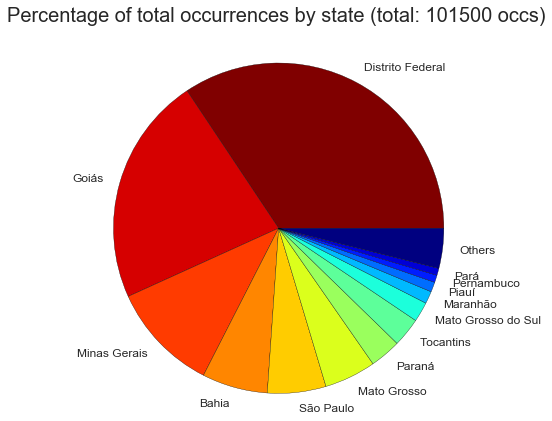

In [14]:
def formatDataToPie(df, groupby, numOfGroups=10 ):
    data =  df[groupby].value_counts()[:numOfGroups-1]
    othersCount = df[groupby].value_counts()[numOfGroups-1:].sum()
    return data.append(pd.Series(othersCount, index=['Others']))

len_dset = ub_dset.shape[0]
formatDataToPie(ub_dset, 'stateProvince', numOfGroups=14).plot.pie(cmap='jet_r', fontsize=12, figsize=(6,6))
plt.axis('equal')
plt.axis('off')

plt.title("Percentage of total occurrences by state (total: {} occs)"\
        .format(len_dset), fontsize=20).set_position([.5,1.1])

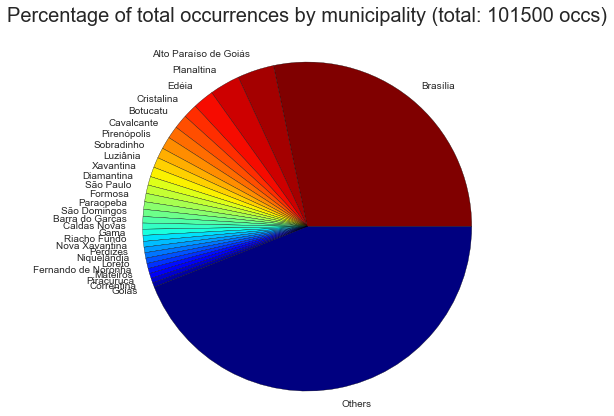

In [15]:
formatDataToPie(ub_dset, 'municipality', numOfGroups=30).plot.pie(cmap='jet_r', fontsize=10, figsize=(6,6))
plt.axis('equal')
plt.axis('off')

plt.title("Percentage of total occurrences by municipality (total: {} occs)"\
        .format(len_dset), fontsize=20).set_position([.5,1.1])

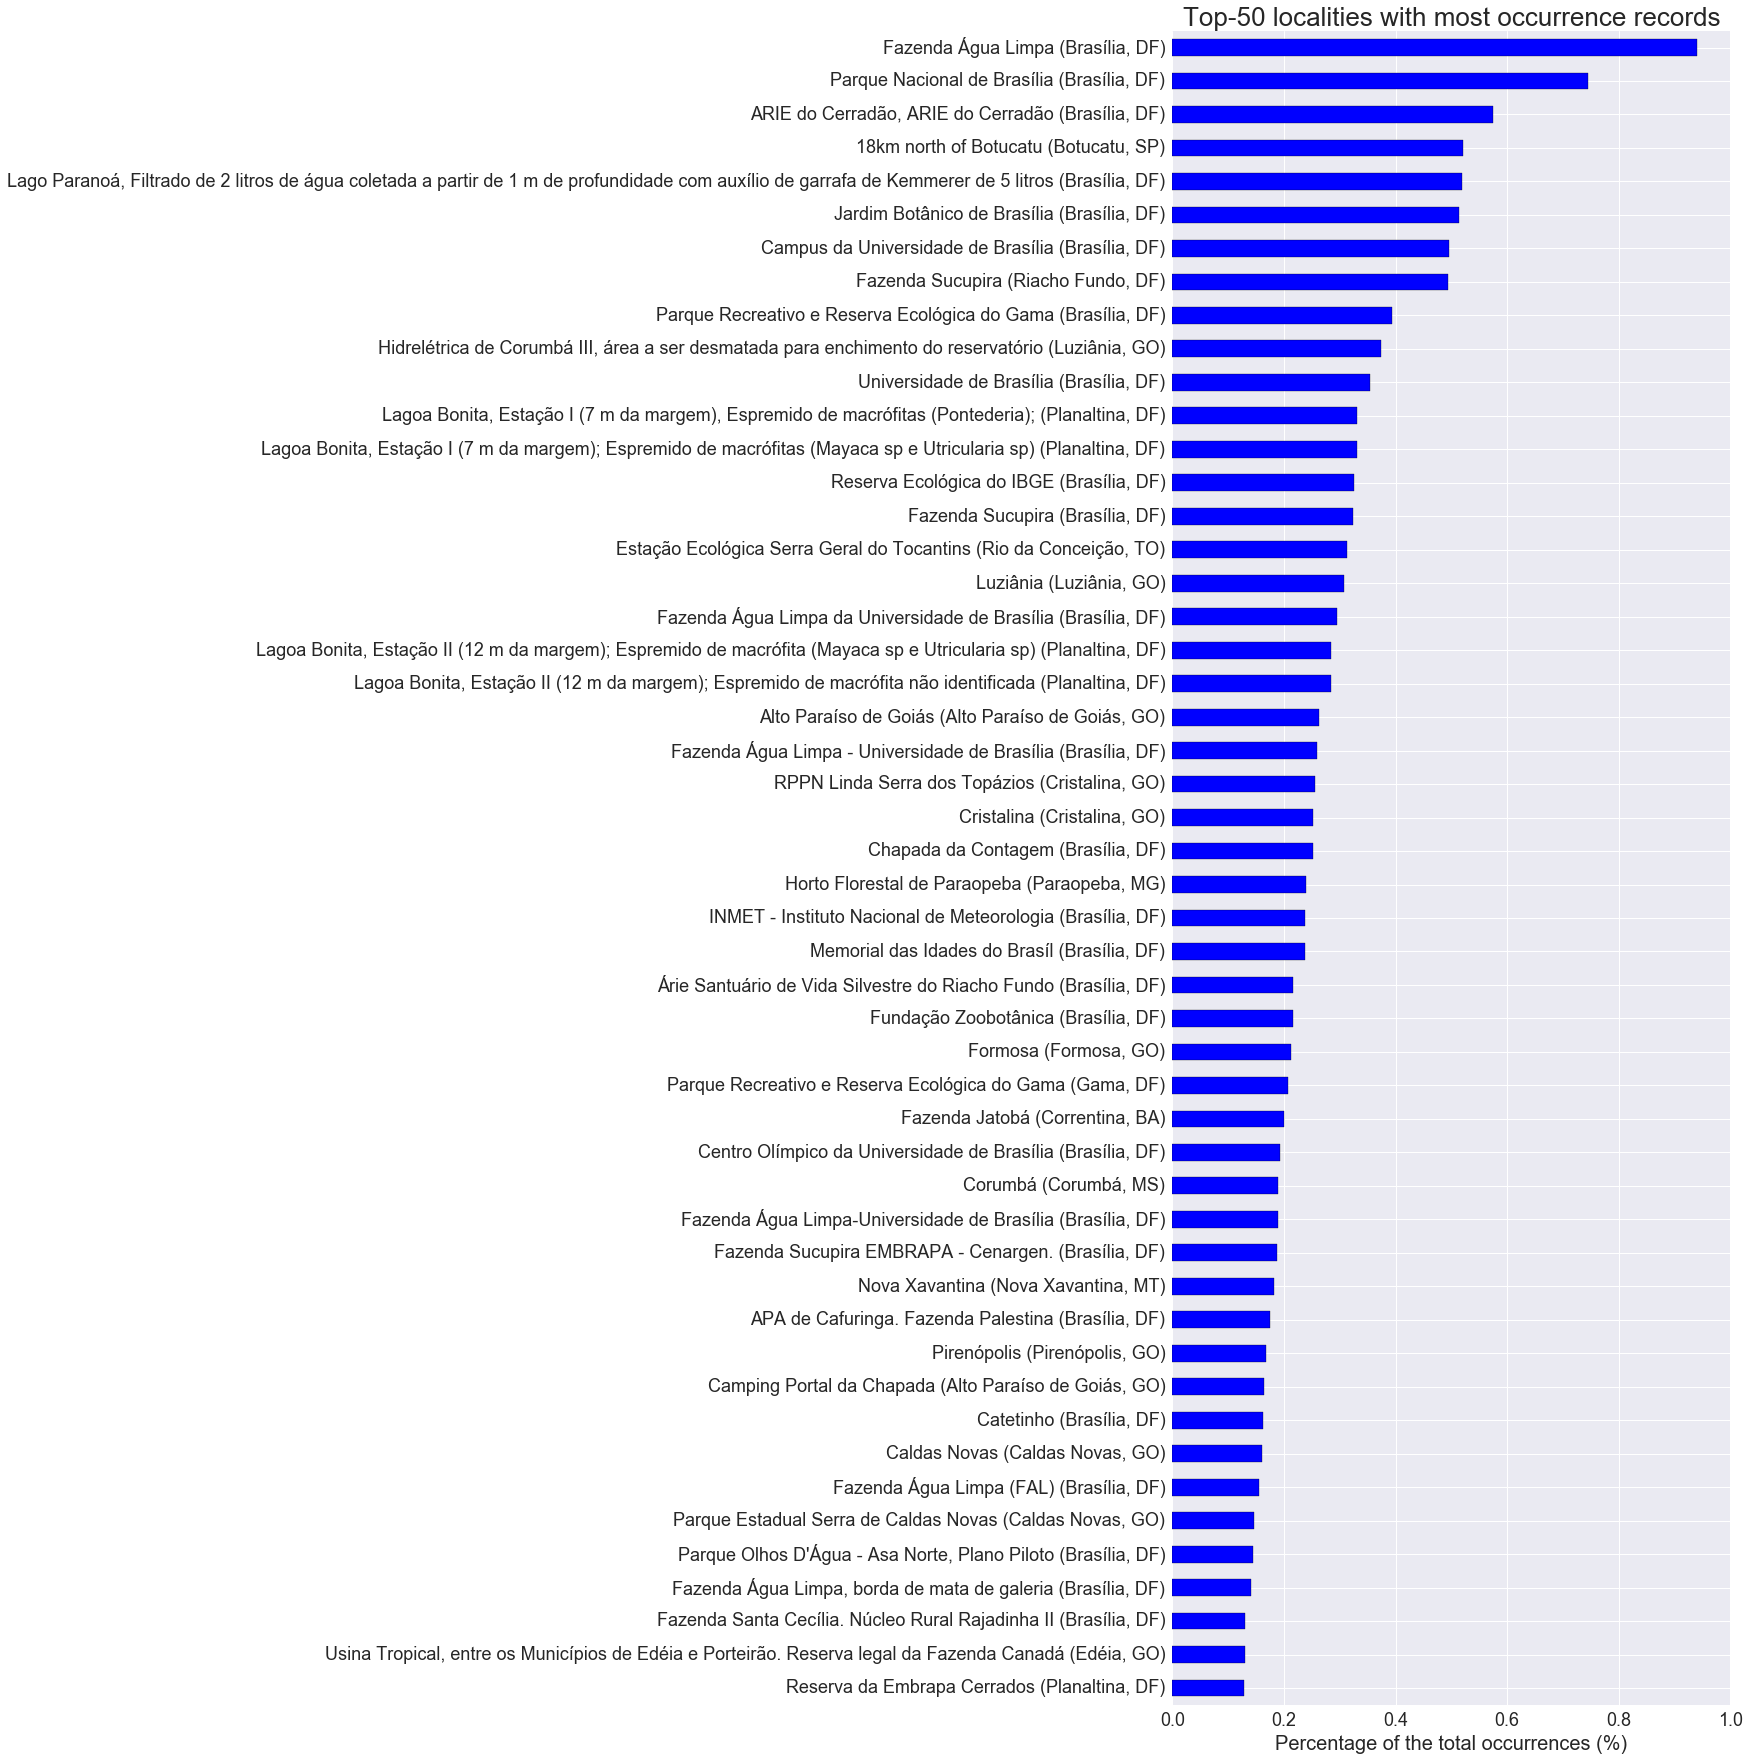

In [16]:
ub_dset['locality_ms'] = ub_dset['locality']+' ('+ub_dset['municipality']+'--'+ ub_dset['stateProvince']

len_dset = ub_dset.shape[0]
ax = ub_dset['locality_ms'].value_counts().apply(lambda cnt: cnt/len_dset*100)[:50]\
    .rename(lambda n: n.split('--')[0]+', '+state_codes[n.split('--')[1]]+')')\
    .sort_values(ascending=True)\
    .plot(kind='barh',figsize=(10,30), fontsize=18)
    
plt.xlabel("Percentage of the total occurrences (%)", fontsize=20)
plt.title("Top-50 localities with most occurrence records", fontsize=26)

From the bar plot above, we see that almost 1% of the entire dataset was recorded on "Fazenda Água Limpa". One issue, however, is that the same locality is being named differently  more than once ("Fazenda Água Limpa da Universidade de Brasília", "Fazenda Água Limpa - Universidade de Brasília", etc.). And I expect that this issue is recurrent throughout the entire dataset. In order to overcome this limitation we would have to employ text mining approaches, which is not on the scope of this notebook. This shows a first issue on working with locality textual data.

Now let's see the distribution of the records located in Brazil in a map. Keep in mind, however, that not all records on the dataset are in Brazil. In fact approximately 1.1% of the records are in other countries. In order to check which occurrences were classified as having country coordinates mismatch, I'll plot non-mismatched records in **blue** and mismatched records in **red**.

In [17]:
ub_dset_br = ub_dset[ub_dset['countryCode']=='BR']

"Percentage of records in Brazil: {:.3}%".format( len(ub_dset_br)/len(ub_dset)*100 )

'Percentage of records in Brazil: 98.8%'

In [18]:
ub_dset_br_ctryMismatch = ub_dset_br[[ 'COUNTRY_COORDINATE_MISMATCH' in i for i in ub_dset_br['issue'] ]]
ub_dset_br_ctryNotMismatch = ub_dset_br[[ 'COUNTRY_COORDINATE_MISMATCH' not in i for i in ub_dset_br['issue'] ]]

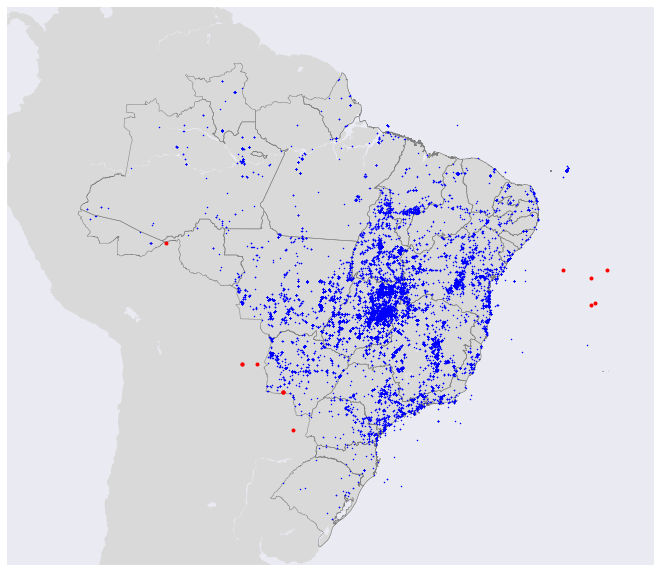

In [19]:
myMap = Basemap(projection='merc',
                    urcrnrlat=10, urcrnrlon=-25, 
                    llcrnrlat=-35, llcrnrlon=-80,
                    lat_ts=20, resolution='l')

myMap.fillcontinents(color='0.85')

shp = myMap.readshapefile('./shapefiles/BRA_adm1', 'states', drawbounds=True, color='0.5')

# plot non-mismatched records in blue
sp_coords = ub_dset_br_ctryNotMismatch[['decimalLatitude', 'decimalLongitude']]
x, y = myMap(sp_coords['decimalLongitude'].values, sp_coords['decimalLatitude'].values)
myMap.plot(x, y, 'bo', markersize=1.5)

# plot mismatched records in red
sp_coords = ub_dset_br_ctryMismatch[['decimalLatitude', 'decimalLongitude']]
x, y = myMap(sp_coords['decimalLongitude'].values, sp_coords['decimalLatitude'].values)
myMap.plot(x, y, 'ro', markersize=4)

plt.show()

From the map above it is clear that filtering the data on the issues declared on the dataset is not sufficient to eliminate incorrect coordinates. On the next notebooks I will explore these issues more thoroughly but by now I just wanted to have a general overview of the records distribution. It is worth noting that there are some record clusters on ecotone regions (biome transitions), and this can be verified by comparing the map above with a map of brazilian biomes.

# 3. Network Models
<a name="3"></a>

The graphs generated on this notebook are available for download [here](.notebook1_graphs.zip)

## 3.1 Collector-species network at Fazenda Água Limpa
<a name="3.1"></a>

Here I will investigate, only considering the location 'Fazenda Água Limpa', who have collected which species (assuming that their taxonomic identification is correct). For that I'll build a Bipartite Graph $ G=(S_{col}, S_{sp}, E) $ where $S_{col}$ is the set of nodes referring to a collector and $S_{sp}$ is the set of nodes referring to a species and edges on the edgeset $E$ only exist between nodes from different node sets. Note that each species and collectors are represented uniquely as nodes within their respective node sets, regardless of their frequency on the dataset. Edges represent the existance of a relationship "species has been collected by collector" (conversely "collector has collected species").

We will possibly verify that some collectors were responsible for recording many species (e.g. professors or herbarium staff) whereas others have contributed with fewer species (e.g. students or lab interns). We can later on verify temporal aspects on the records. For example, as some collectors are older, and due to equipment limitations due to temporality information such as georeference quality might vary. Also, depending on his/her speciality, collectors might sample their preferred taxonomic group, leading to 'taxonomic sampling bias'.

The following routine builds a set of $(collector\_name, species\_name)$ tuples from the records for Fazenda Água Limpa. After some processing these tuples will be used to compose the graph edgeset.

In [20]:
fal_data = ub_dset[ ub_dset['locality']=='Fazenda Água Limpa' ]

collectors = list( fal_data[['recordedBy','scientificName','family']].groupby('recordedBy') )
collector_sps = set([ (collector, sp) for collector, data in collectors for sp in data['scientificName'] ])

In [21]:
[ (c,sp) for c,sp in collector_sps ][:5]

[('Kirkbride Junior, JH', 'Periandra mediterranea (Vell.) Taub.'),
 ('Cesar, HL', 'Agenium goyazense (Hack.) Clayton'),
 ('Ratter, JA', 'Periandra mediterranea (Vell.) Taub.'),
 ('Kirkbride, MCG', 'Elephantopus biflorus (Less.) Sch.Bip.'),
 ('Amaral, AG; Eugênio, CUO; Munhoz, CBR',
  'Leandra polystachya (Naud.) Cogn.')]

Not all entries for 'collector' are atomic, however. There are tuples in which $collector\_name$ actually refers to a list of collector names:

In [22]:
[ c for c,sp in collectors if len(c.split(';'))>1 ][:5]

['Amaral, AG; Eugênio, CUO',
 'Amaral, AG; Eugênio, CUO; Munhoz, CBR',
 'Amaral, AG; et al.',
 'Araújo, MF; Schmidt, IB; Medeiros, CRP',
 'Caires, CS; Ramalho, CL; Mendes, VC; Ribeiro, MF']

As each node on the graph must represent uniquely each entity, collector names on each tuple must be made atomic before proceeding. The following routine fixes this issue, iterating through the edgeset and creating atomic tuples for each of these entries: 

In [23]:
tpls_to_remove=set()
tpls_to_add=set()

for tpl in collector_sps:
    collectors_list = tpl[0].split(';')
    sp = tpl[1]
     
    if len(collectors_list) > 1:      
        tpls_to_remove.add(tpl)
        for collector in collectors_list:
            if collector!='':
                tpls_to_add.add( (collector.strip(), sp) )
            
collector_sps = collector_sps.difference(tpls_to_remove).union(tpls_to_add)

# assert there are no more collector names separated by ';'
assert( len([ (c,sp) for c,sp in collector_sps if len(c.split(';'))>1 ])==0 )

And now we can finally build the graph from the tuples. The graphs generated throughout this notebook will be exported for external visualization.

In [24]:
G = nx.Graph(name='Collector-Species')
G.add_nodes_from( [ i[0] for i in collector_sps ], bipartite=0 )
G.add_nodes_from( [ i[1] for i in collector_sps ], bipartite=1 )
G.add_edges_from( collector_sps )

In [25]:
print('About the graph: \n===============\n'+nx.info(G))
print('Number of S_col nodes: {}'.format( len([ n for n,data in G.nodes(data=True) if data['bipartite']==0 ]) ))
print('Number of S_sp nodes: {}'.format( len([ n for n,data in G.nodes(data=True) if data['bipartite']==1 ]) ))

About the graph: 
Name: Collector-Species
Type: Graph
Number of nodes: 633
Number of edges: 970
Average degree:   3.0648
Number of S_col nodes: 199
Number of S_sp nodes: 434


### 3.1.1 Who have collected more species?
<a name="3.1.1"></a>

A first aspect we might want to investigate on this graph is who are the most active collectors. Besides pointing out the top-5 hubs (those collectors who have recorded many different species) ranked by column *num_species*, the table below also shows the total number of records (specimens) achieved by each of them (column *num_records*). Note that sampling effort cannot be purely estimated by means of the nodes degree. As a high degree is a good indicative that a particular collector is an experient field worker, it does not take into account the number of records they have obtained. As a consequence a specialist field worker, mostly interested on sampling a more restricted subset of species, would be considered to have a lower position in a pure-degree ranking. Therefore accounting for the total number of records might be very informative depending on our analysis. 

In [26]:
collectors_dict = dict([ (n,0) for n,data in G.nodes(data=True) if data['bipartite']==0 ])

for collectors in [ row for idx,row in fal_data['recordedBy'].items() ]:
    for key in collectors_dict.keys():
        if key in collectors:
            collectors_dict[key]+=1
            
pd.DataFrame(dict(
        num_species = dict( [(n,G.degree(n)) for n,data in G.nodes(data=True) if data['bipartite']==0] ),
        num_records = collectors_dict
    )).sort_values(by='num_species', ascending=False)[:5]

num_records  num_species
Ratter, JA              221          153
César, HL                78           74
Haridasan, M             97           65
Munhoz, CBR              39           36
Kirkbride, MCG           46           36

### 3.1.2 Which species were most collected by different collectors?
<a name="3.1.2"></a>

The top-5 species hubs might be also assessed similarly as we've done to collectors nodes. Here the hubs are those species that have been most collected by different collectors. Also hubs are not necessarily those nodes whith most occurrence records. In fact *Qualea parviflora* has been recorded 15 times by 10 different collectors, whereas *Qualea grandiflora* have been collected 13 times by 13 different collectors. There might be on the dataset species that although having low degree (recorded by less collectors) could have been recorded a lot of times. This could be the case, for example, if there were a small group of specialists interested on studying phenologic aspects of a particular species.

In [27]:
pd.DataFrame(dict(  
        num_collectors = dict([ (n,G.degree(n)) for n,data in G.nodes(data=True) if data['bipartite']==1 ]),
        num_occurrences = fal_data['scientificName'].value_counts()
    )).sort_values(by='num_collectors', ascending=False)[:5]

num_collectors  num_occurrences
Qualea grandiflora Mart.                        13               13
Vochysia elliptica Mart.                        12               11
Plenckia populnea Reiss.                        12               11
Qualea parviflora Mart.                         10               15
Pterodon pubescens (Benth.) Benth.              10               11

Having considered the aspects above we can now plot the nodes and check the graph structure. Collector and species nodes are plotted in **blue** and **red** respectively, and their size vary with degree. In attempt to give a better visualization experience I have also highlighted the higher-degree collector nodes and the species connected to them. Despite my effort in making the graph better for static visualization inside the notebook, there are specialized software which offer much more appropriate tools for graph visualization (such as *gephi* or *cytoscape*).

In [28]:
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Fazenda Água Limpa: Collector-species network', fontsize=18)
fig.axes[0].patch.set_alpha(0)

pos=nx.spring_layout(G, iterations=100, scale=6, weight=100)

# set node colors
nx.set_node_attributes( G, "color", dict([ (n, ('r' if data['bipartite']==1 else 'royalblue') ) for n,data in G.nodes(data=True) ]) )

# set node sizes
nx.set_node_attributes( G, "size", dict([ (n, G.degree(n)*10) for n,data in G.nodes(data=True) ]) )


# plot all nodes (transparent)
nodes = [ n for n in G.nodes(data=True) ]
draw = nx.draw_networkx_nodes(G, pos, nodelist=[n for n,data in nodes],  
                       node_color=[ data['color'] for n,data in nodes ], 
                       node_size=[ data['size'] for n,data in nodes ],
                       alpha=0.25 )

nx.draw_networkx_edges(G, pos, edgelist=[ e for n in G.nodes() for e in G.edges(n)], width=0.2, alpha=0.2)
mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n,data in nodes ]))


# plot highest degree collectors
hl_col_nodes = [ (n,data) for n,data in G.nodes(data=True) if G.degree(n)>30]
draw = nx.draw_networkx_nodes(G, pos, nodelist=[n for n,data in hl_col_nodes],
                      node_color=[ data['color'] for n,data in hl_col_nodes ],
                      node_size=[ data['size'] for n,data in hl_col_nodes ],
                      alpha=0.8)

nx.draw_networkx_edges(G, pos, edgelist=[ e for n,data in hl_col_nodes for e in G.edges(n) ], width=0.2, alpha=0.4)
mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n,data in hl_col_nodes ]))


# plot the species the highest degree collectors have recorded
nb_nodes = [ (neigh, G.node[neigh]) for n,data in hl_col_nodes for neigh in G.neighbors(n) ]
draw = nx.draw_networkx_nodes(G, pos, nodelist=[ n for n,data in nb_nodes ],
                      node_color=[ data['color'] for n,data in nb_nodes ],
                      node_size=[ data['size'] for n,data in nb_nodes ],
                      label = [ n for n,data in nb_nodes ],
                      alpha=0.6)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n,data in nb_nodes ]))


mpld3.display()

The frames in which the networks are plotted on this notebook are interactive and the user is able to **move**, **zoom in** and **out** using the toolbar on the bottom-left corner of the figure. Also the nodes id can be checked by hovering the cursor on top of them.

If we zoom into the central component of the network we verify that apparently the hubs share records on some higher-degree species, although they are also linked to some exclusive lower-degree ones. Moreover, there is a group of collectors that apparently share a greater number of species (Munhoz, Eugênio and Amaral), and are therefore more strongly associated. It might be the case that they are experts interested on similar taxonomic or functional groups. If we take a closer look at the region of the graph in which these three nodes are we can identify a particular species (*Aspilia foliaceae*) that is also linked to a group of 1-degree collectors. One of these nodes refer to the biology program course *Organografia e Sistemática das Fanerofíticas*. Would this pattern (many 1-degree collector nodes linked to a species) be representing a group of students in fieldwork? Finding such patterns or motifs in the network could be invaluable if we were to systematically account for the particularities and context in which occurrences were obtained. This knowledge could be ultimatelly applied for many goals, among other quantifying sampling effort for different taxonomic/functional groups, identifying possibly subsampled regions or prioritize records to be re-evaluated by experts.

### 3.1.3 Which collectors are specialists and which are generalists?
<a name="3.1.3"></a>

Specialist collectors focus their field work on recording particular taxonomic or functional groups whereas generalists are mostly interested on assessing species diversity on localities. The expertise profiles of the collectors who have recorded species in a region probably affects the characterization of a community in terms of its species diversity and abundance. If we consider all occurrences in a given locality as a sample, it is a considerably biased sample. Maybe assessing each collector's expertise profile could help us to characterize the bias on the sample.

On this section I will try to identify possible specialist groups and generalists on the network. Concretely for the sake of simplicity I will look for specialists on the group of herbaceous plants, although many other groups could be used instead. The list below is a rough classification of families that contain herbaceous species. However, for a finer analysis we would want to consider the functional group of species instead of families, as some families (e.g. Fabaceae) are highly diverse in terms of habit. Conversely there are also herbaceous species belonging to families different from the ones listed. 

In [29]:
herb_families = ['Acanthaceae', 'Apiaceae', 'Asteraceae', 'Convolvulaceae', 
                 'Cyperaceae', 'Eriocaulaceae', 'Euphorbiaceae', 'Fabaceae',
                 'Flacourtiaceae', 'Lamiaceae', 'Lythraceae', 'Malpighiaceae',
                'Myrtaceae', 'Ochnaceae', 'Orchidaceae', 'Poaceae', 'Polygalaceae',
                'Rubiaceae', 'Simaroubaceae', 'Smilacaceae', 'Turneraceae', 'Xyridaceae']

First I'll build a dictionary mapping species name to family, and then for each species node I'll add a binary attribute *herb*, representing whether the species is herbaceous or not.

In [30]:
# build a dictionary mapping species name to family
sp_family_dict=dict()
for idx, r in fal_data[['scientificName','family']].iterrows():
    sp_family_dict[r[0]]=r[1]

In [31]:
# add family and herb attribute to nodes
for sp,data in [ (sp_node,data) for sp_node,data in G.nodes_iter(data=True) if data['bipartite']==1 ]:
    data['family'] = sp_family_dict[sp]
    data['herb'] = data['family'] in herb_families

In [32]:
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Specialists and generalists in the network', fontsize=18)
fig.axes[0].patch.set_alpha(0)

# draw collector nodes
col_nodes = [ (n,data) for n,data in G.nodes(data=True) if data['bipartite']==0 ]
draw = nx.draw_networkx_nodes(G, pos=pos, 
        nodelist = [ n for n,data in col_nodes ],
        node_color = 'royalblue', alpha=0.3, 
        node_size = [ data['size'] for n,data in col_nodes ])

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n,data in col_nodes ]))


# draw highlighted collector nodes
hl_col_nodes = [ (n,data) for n,data in G.nodes(data=True) if G.degree(n)>30]
draw = nx.draw_networkx_nodes(G, pos=pos, 
        nodelist = [ n for n,data in hl_col_nodes ],
        node_color = 'royalblue', alpha=0.9, 
        node_size = [ data['size'] for n,data in hl_col_nodes ])

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n,data in hl_col_nodes ]))


# draw species nodes
sp_nodes = [ (n,data) for n,data in G.nodes(data=True) if data['bipartite']==1 ]
draw = nx.draw_networkx_nodes(G, pos=pos, 
        nodelist = [ n for n,data in sp_nodes ],
        node_color = [ 'darkorange' if data['herb']==1 else 'firebrick' for n,data in sp_nodes ], 
        node_size = [ data['size'] for n,data in sp_nodes ], alpha=0.2)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n,data in sp_nodes ]))


# draw highlighted species nodes
hl_sp_nodes = [ (sp,G.node[sp]) for col,data in hl_col_nodes for sp in G.neighbors(col) ]
draw = nx.draw_networkx_nodes(G, pos=pos, 
        nodelist = [ n for n,data in hl_sp_nodes ],
        node_color = [ 'darkorange' if data['herb']==1 else 'firebrick' for n,data in hl_sp_nodes ], 
        node_size = [ data['size'] for n,data in hl_sp_nodes ], alpha=0.8)

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ n for n,data in hl_sp_nodes ]))


nx.draw_networkx_edges(G, pos, edgelist=[ e for n in G.nodes() for e in G.edges(n)], width=0.2, alpha=0.1)
nx.draw_networkx_edges(G, pos, edgelist=[ e for n,data in hl_col_nodes for e in G.edges(n) ], width=0.2, alpha=0.4)
nx.write_gexf(G, os.path.join(graph_save_dir, 'graph31.gexf'))

mpld3.display()

On this graph **orange** and **red** nodes refer to herbaceous and non-herbaceous species respectively, whereas **blue** nodes represent collectors. A quick inspection reveals that the group of nodes (Munhoz, Amaral and Eugênio) are particulary interested on herbaceous species and probably have done fieldwork together. The other collectors apparently do not show a preference for herbaceous or non-herbaceous species. Although at this moment I have only visually detected this group, there are network clustering metrics that could help us identify these groups more automatically.

## 3.2 Species co-occurrence network
<a name="3.2"></a>

One question we might ask is whether the species composition on a geographic region (biological community) can be used to ecologically characterize it, allowing us to classify localities by their similarities. Also, could there be sets of species which are strongly positively or negatively associated to others, in such a manner that a the existance (or absence) of a particular species existance could be inferred based on others already sampled for that location?

On this section I will build species co-occurrence networks, in which species are associated to each other in case they were observed on the same localities. There are several authors on the scientific literature interested on this kind of modeling for many purposes, for example for detecting natural units of sympatric species:
>Dos Santos D a, Fernández HR, Cuezzo MG, Domínguez E. **Sympatry inference and network analysis in biogeography**. Syst Biol. Oxford University Press; 2008 Jun ;57(3):432–48.

or for assessing the impact of climate change on natural communities:
> Araújo MB, Rozenfeld A, Rahbek C, Marquet PA. **Using species co-occurrence networks to assess the impacts of climate change**. Ecography (Cop). Blackwell Publishing Ltd; 2011 Dec;34(6):897–908.

In order to build a co-occurrence network we must establish rules for inferring which species should be considered as occurring together. These rules will vary depending on the scale of our analysis, as we may want to group species to look at more local or global patterns. This is in fact a decision we must take before the modeling process, as the method chosen for grouping species will limit the kinds of questions we might answer with the model. Many algorithms for geographical grouping of occurrence records have been proposed.

On this notebook however I will not group species based on geographic coordinates yet. To keep the simplicity of this first exploratory analysis I will perform two trials, grouping occurrence records by state and then by locality. Similarly to the collector-species networks, I will build a bipartite network $G = (S_{locs}, S_{sp}, E)$, in which $S_{locs}$ is the set of locality nodes, $S_{sp}$ is the set of species nodes and $E$ is the edgeset.

 ### 3.2.1 Species co-occurrence at the state scale
 <a name="3.2.1"></a>

Do adjacent states share more species than non-adjacent ones? I will try to answer this question by building a bipartite graph using state boundaries as a criterion for inferring co-occurrence. Species that were recorded at least once in a given state are linked to it. On this trial I will only use records within Brazilian states.

In [33]:
# remove the only record for Guanabara state
groups = ub_dset_br[ub_dset_br['stateProvince']!='Guanabara'].groupby('stateProvince')

edgeset = set([ (group, sp) for group,data in groups for sp in data['scientificName'] ])
loc_nodes = set([ loc for loc,sp in edgeset ])
sp_nodes = set([ sp for loc,sp in edgeset ])

G = nx.Graph(name='Co-occurrence_state')
G.add_nodes_from(loc_nodes, bipartite=0)
G.add_nodes_from(sp_nodes, bipartite=1)
G.add_edges_from(edgeset)

nx.write_gexf(G, os.path.join(graph_save_dir, 'graph321.gexf'))

In [34]:
print('About the graph: \n===============\n'+nx.info(G))
print('Number of S_loc nodes: {}'.format( len([ n for n,data in G.nodes(data=True) if data['bipartite']==0 ]) ))
print('Number of S_sp nodes: {}'.format( len([ n for n,data in G.nodes(data=True) if data['bipartite']==1 ]) ))

About the graph: 
Name: Co-occurrence_state
Type: Graph
Number of nodes: 12538
Number of edges: 26264
Average degree:   4.1895
Number of S_loc nodes: 27
Number of S_sp nodes: 12511


Considering the high number of edges on this network and the relatively low performance of networkx for graph visualization I will not plot it as it is. Instead I'll project the graph on the locations set $S_{loc}$. The projected graph will only contain state nodes which will be linked with a weight proportional to the number of species they share. One drawback of this naive approach is that more sampled regions will be more strongly linked only because of the higher sampling effort.

In [35]:
G_ploc = nx.bipartite.weighted_projected_graph(G,loc_nodes)
nx.write_gexf(G_ploc, os.path.join(graph_save_dir,'graph321_proj.gexf'))

In [36]:
print(nx.info(G_ploc))

Name: Co-occurrence_state
Type: Graph
Number of nodes: 27
Number of edges: 329
Average degree:  24.3704


Now let's take a look at the projected graph. Each edge's weight is represented as its thickness and node's degree as its size.

In [37]:
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Projection of co-occurrence network on Brazilian states', fontsize=18)
fig.axes[0].patch.set_alpha(0)

pos = nx.spring_layout(G_ploc, iterations=30000)

edgelist = G_ploc.edges(data=True)
nodelist = [ n for n in G.degree(loc_nodes).items() ]

nx.draw_networkx_nodes(G_ploc, pos, nodelist=[ i for i,d in nodelist ], node_size=[ d for i,d in nodelist ], alpha=0.6)
nx.draw_networkx_edges(G_ploc, pos, edgelist=edgelist, width=[ d['weight']/250 for n1,n2,d in edgelist ], alpha=0.5)
nx.draw_networkx_labels(G_ploc, pos, font_size=14)


mpld3.display()

The result is not very informative though. I would have expected that the proximity of each node were related to their geographic adjacency, although this was not the case. The spring algorithm used to generate this plot tends to move lower degree nodes farther away while keeping hubs on the center. Nodes belonging to network communities, however, are expected to be kept close. The absence of communities on the network might be explained by the fact that most collectors who have collected for the UB herbarium were interested on Cerrado regions on these states, and therefore communities from other biomes were not accounted for distinguishing states. Maybe a dataset that is more homogeneous in terms of functional groups sampling might show more positive results.

### 3.2.2 Species co-occurrence at the locality scale
<a name="3.2.2"></a>

I will try to answer a similar question to the one on the last section, but now refining the scale of species grouping. Do locations on the same state share more species than locations on different states? Here I will use the top-5 localities with more records for each state. The routine below performs the filtering.

In [38]:
# filter dataset with localities with more records for each state

locs_dict = dict()
for state in list(ub_dset_br['stateProvince'].unique()):
    groups = ub_dset_br[ub_dset_br['stateProvince']==state].groupby('locality').size().sort_values(ascending=False)[:5]
    localities = list(groups.index)
    locs_dict[state] = [l for l in list(groups.index)]
    
locs_list = [ j for i in locs_dict.values() for j in i ]

ub_dset_loc = ub_dset_br[ ub_dset_br['locality'].isin(locs_list) ]

Now the graph is built

In [39]:
groups = ub_dset_loc.groupby('locality')

edgeset = set([ (group, sp) for group,data in groups for sp in data['scientificName']])
loc_nodes = [ loc for loc,sp in edgeset ]
sp_nodes = [ sp for loc, sp in edgeset ]

G = nx.Graph(name='Co-occurrence_locality')

for state in locs_dict.keys():
    G.add_nodes_from(locs_dict[state], state=state_codes[state], bipartite=0)

G.add_nodes_from(sp_nodes, bipartite=1)
G.add_edges_from(edgeset)

nx.write_gexf(G, os.path.join(graph_save_dir, 'graph322.gexf'))

In [40]:
print('About the graph: \n===============\n'+nx.info(G))
print('Number of S_loc nodes: {}'.format( len([ n for n,data in G.nodes(data=True) if data['bipartite']==0 ]) ))
print('Number of S_sp nodes: {}'.format( len([ n for n,data in G.nodes(data=True) if data['bipartite']==1 ]) ))

About the graph: 
Name: Co-occurrence_locality
Type: Graph
Number of nodes: 3270
Number of edges: 6117
Average degree:   3.7413
Number of S_loc nodes: 136
Number of S_sp nodes: 3134


For visualizing the graph I will color the locality nodes based on the state they belong to. In order to keep the figure cleaner I will not distinguish the degree of the nodes, athough this is a good aspect to look at if you open the graph in an external graph visualization tool. I will use the rainbow colormap, and try to list the states in such a manner that those in similar ecological regions will have closer colors. You can verify the state id of the nodes by hovering the cursor on top of them. Species nodes will be displayed in red with transparency.

In [41]:
pos = nx.spring_layout(G)

In [42]:
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Co-occurrence network on Brazilian localities, colored by state', fontsize=18)
fig.axes[0].patch.set_alpha(0)


states = ['AM', 'RO', 'RR', 'AP', 'AC', 'PA',
          'PI', 'CE', 'RN', 'PB', 'PE', 'SE', 'AL', 'BA',
          'MA', 'MT', 'MS', 'TO', 'GO', 'DF',
          'MG', 'SP', 'ES', 'RJ', 'PR',
          'SC', 'RS'
          ]

loc_nodes = [ (n,data) for n,data in G.nodes(data=True) if data['bipartite']==0 ]
sp_nodes = [(n,data) for n,data in G.nodes(data=True) if data['bipartite']==1 ]


# make colormap for 27 states
cmap = plt.cm.rainbow
states_linspace = np.linspace(0,1,27)
norm = mpl.colors.BoundaryNorm(states_linspace, cmap.N)
colors = [ cmap(norm(state_i)) for state_i in states_linspace]
state_color_dict = dict(list(zip(states,colors)))


# draw species nodes
nx.draw_networkx_nodes(G, pos=pos, node_size=10, alpha=0.2,
                       nodelist=[ n for n,data in sp_nodes ])


# draw locality nodes colored by state
draw = nx.draw_networkx_nodes(G, pos=pos,
                       nodelist=[n for n,data in loc_nodes], 
                       node_size = 100, #[ G.degree(n)*10 for n,data in loc_nodes ],
                       node_color = [ state_color_dict[data['state']] for n,data in loc_nodes ] )

mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(draw, labels=[ data['state'] for n,data in loc_nodes ]))

# draw edges
nx.draw_networkx_edges(G, pos=pos, width=0.3, alpha=0.2)


mpld3.display()

By inspecting the central connected component of the graph we can check that apparently there is a region with a rough cluster of bluish nodes, which are mainly located on north-northeastern regions. The center of the plot contains mainly nodes from central Brazil, which is the most thoroughly sampled region on the dataset. However, there is still not a visible formation of groups in this graph, and this might be due to a higher sample effort into Cerrado communities of each state. Maybe by focusing the analysis on ecotone regions (transitions between biomes) which are mostly subsampled and excluding the hub localities we would be able to better distinguish the communities in each ecotone region. 

# 4. Conclusions
<a name="4"></a>

* The GBIF dataset is roughly preprocessed for some geographic issues associated with each occurrence record. However it is essential to come up with solutions for filtering incorret coordinates at finer scales. Simple routines based on geographic analysis can be performed such as checking if coordinates for each record are in fact located into the municipality/state boundaries. Detecting issues at finer scales than municipality is more complex, and requesting validation of records by specialists may be the only viable solution currently.

* Performing analyses on datasets with heterogeneous geographic distribution must be done with caution. It might be a good idea to try to understand why, how and by whom the dataset was built. The UB dataset, for example, is apparently biased towards species from Cerrado regions, and most of the collectors might be interested on particular functional or taxonomic groups. 

* Maybe species-collector networks could give us information on whom are the collectors responsible by the records they collect, and how their profile could incur on a biased sampling. If we considered using records from generalist instead of expert collectors, for example, we could be able to better assess differences on the overall species diversity of localities. On the other hand if we use records from specialists we might get better information regarding the distribution of those particular groups they're interested on. This kind of analysis could help us to structure and understand the dataset in terms of records the context in which the records were obtained.